In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

# context imports
from PdmContext.ContextGeneration import ContextGenerator
from PdmContext.utils.causal_discovery_functions import calculate_with_pc

# methods and utils
from utils import find_length
from sand_core import SAND


/home/agiannoul/anaconda3/envs/context_pdm/lib/python3.10/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


### Read and plot availiable data:
- public holidays of NY
- temperature of NY
- taxi demand

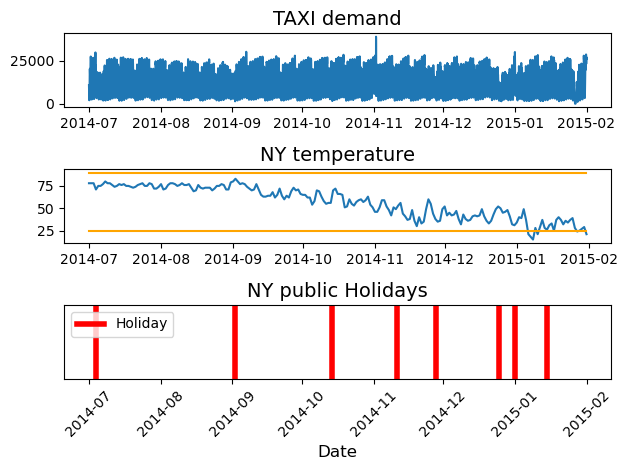

In [2]:
def read_data():
    df1 = pd.read_csv("nyc_taxi.csv",index_col=0)
    df1.index= pd.to_datetime(df1.index)
    plt.subplot(311)
    plt.plot(df1.index,df1['value'])
    df=df1.to_numpy()
    plt.title("TAXI demand", fontsize=14)
    dftemp=pd.read_csv("temp_data.csv",header=0,index_col=1)
    dftemp.index= pd.to_datetime(dftemp.index)
    dftemp=dftemp[["Mean.TemperatureF"]]
    tempdata=dftemp["Mean.TemperatureF"].values.astype(float)

    extrem_weather=[1 if tm>90 or tm<25 else 0 for tm in tempdata]
    extrem_weather=[0]+[1 if extrem_weather[i-1]!=extrem_weather[i]  else 0 for i in range(1,len(extrem_weather))]
    
    
    plt.subplot(312)
    plt.title("NY temperature", fontsize=14)
    plt.plot(dftemp.index,tempdata)
    plt.plot(dftemp.index,[90 for t in tempdata],color="orange")
    plt.plot(dftemp.index,[25 for t in tempdata],color="orange")
    tempdata=extrem_weather

    data = df[:, 0].astype(float)
    
    # independance, thanks giving, christamas, 1st januarry,
    # List of official holidays (for example, US public holidays in 2024)
    holidays = [
        "2014-07-04",  # Independence Day
        "2014-09-02",  # Labor Day
        "2014-10-14",  # Columbus Day
        "2014-11-11",  # Veterans Day
        "2014-11-28",  # Thanksgiving
        "2014-12-25",   # Christmas Day
        "2015-01-01",  # New Year's Day
        "2015-01-15",  # Martin Luther King Jr. Day
    ]
    holidays = pd.to_datetime(holidays)

    plt.subplot(313)
    plt.plot(df1.index,[0 for i in df1.index],color="white")
    for holiday in holidays:
        plt.axvline(holiday, color='red', linewidth=4, label='Holiday' if holiday == holidays[0] else "")
    
    plt.title("NY public Holidays", fontsize=14)
    plt.xlabel("Date", fontsize=12)
    plt.yticks([])  # Hide the y-axis
    plt.legend(loc='upper left')

    # Rotate the x-axis labels for better readability
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Show the plot
    plt.show()

    change_hours=[pd.to_datetime("2014-11-01 23:00:00")]
    return df1,holidays,change_hours,data,dftemp,tempdata,extrem_weather
df1,holidays,change_hours,data,dftemp,tempdata,extrem_weather=read_data()

### Generate Anomaly score

Use SAND anomaly detection to calculate anomaly scores for taxi demand Time-series

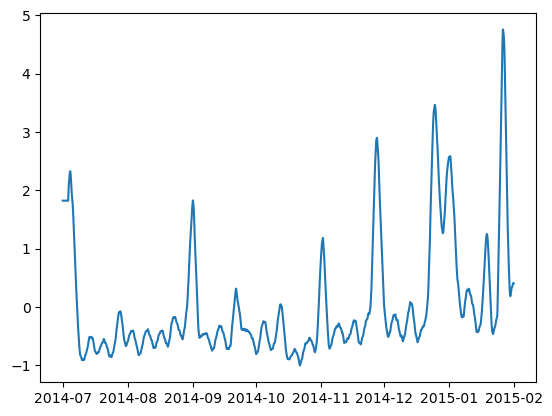

In [3]:
def apply_SAND(data):
    slidingWindow = find_length(data)
    clf = SAND(pattern_length=slidingWindow,subsequence_length=4*(slidingWindow))
    x = data
    clf.fit(x,overlaping_rate=int(1.5*slidingWindow))
    score = clf.decision_scores_
    return score
score=apply_SAND(data)
plt.plot(df1.index,score)
plt.show()

### Use context to provide meta-feature explanations

To do that we will gather all availiabe sources (holidays, change hour events, extreme weather, anomaly scores) and feed them to the context generator.

100%|██████████| 10335/10335 [00:28<00:00, 367.29it/s]


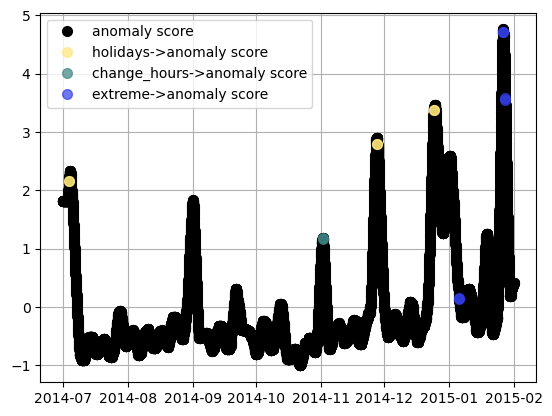

In [9]:
%matplotlib inline 
def context_results(df1,holidays,change_hours,extrem_weather,dftemp,score):
    from PdmContext.utils.simulate_stream import simulate_stream

    # collect all availiable information
    eventconf2 = ("holidays", holidays, "isolated")
    spiketuples2 = ("change_hours", change_hours, "isolated")
    spiketuples3 = ("extreme", [dt for dt, ext in zip(dftemp.index, extrem_weather) if ext == 1], "isolated")
    anomaly1tuples2 = ("anomaly score", score, df1.index)

    # simulate the stream (proccess data as streams) 
    stream = simulate_stream([anomaly1tuples2], [eventconf2, spiketuples2, spiketuples3],[], "anomaly1")

    # instantiate a context generator
    context_generator = ContextGenerator(target="anomaly score", context_horizon=f"{14 * 24} hours",
                                        Causalityfunct=calculate_with_pc)
    source = "taxi"

    c = 0
    all_records=[]
    for record in stream:
        all_records.append(record)
    context_list=[]
    # incrementaly add the stream of data to the context
    for q in tqdm(range(len(all_records))):
        record=all_records[q]
        context_object=context_generator.collect_data(timestamp=record["timestamp"], source=source, name=record["name"],
                                      type=record["type"], value=record["value"])
        if context_object is not None:
            context_list.append(context_object)
    # plot the results
    context_generator.plot_interpretation(context_list,[["", "", ""]])
    return context_list,context_generator
context_list,context_generator=context_results(df1,holidays, change_hours, extrem_weather, dftemp, score)